In [1]:
# Import libraries
from numpy import array, eye, hstack, empty, ones, zeros, sqrt, diag, arctan2,\
                  trace, vstack, argmax, set_printoptions
from numpy.linalg import inv, norm, eigh
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from lib.convert import rad2deg

# Representation of float numbers in arrays when printed
set_printoptions(formatter={'float_kind':"{:.2f}".format})


# Navigation modes
mode = 'circular'
# mode = 'circular_bias'
# mode = 'hyperbolic'


# Error ellipse2D
def error_ellipse2D(xc, yc, cov, sigma=1, **kwargs):
    eigval, eigvec = eigh(cov)        # Assume symmetric matrix
    order = eigval.argsort()[::-1]    # Sort in decending order
    eigval, eigvec = eigval[order], eigvec[:, order]
    theta = rad2deg(arctan2(*eigvec[:, 0][::-1]))
    
    return Ellipse(xy=(xc, yc),
                   width=2*sigma*sqrt(eigval[0]),
                   height=2*sigma*sqrt(eigval[1]),
                   angle=theta, **kwargs)


# Transmitter coordinates [meter]
Xs = array([[80000, 60000],
            [30000, 90000],
            [20000, 30000],
            [80000, 20000],
            [50000, 90000]])


# Approximate receiver position [meter]
x0 = array([[50000],
            [50000]])


# Standard deviation of unit weight (meter)
sigma0 = 25


# Standard deviation of observation (meter)
sigmaz = 25


# Covariance matrix of the observations (meter)
SIGMAz = sigmaz**2*eye(5)


# Observations (meter)
s = array([[31600],
           [44700],
           [36000],
           [42400],
           [40033]])


# Computed observations (meter)
s0 = array([[norm(Xs[0, :] - x0.T)],
            [norm(Xs[1, :] - x0.T)],
            [norm(Xs[2, :] - x0.T)],
            [norm(Xs[3, :] - x0.T)],
            [norm(Xs[4, :] - x0.T)]])


# Observation vector
z = s - s0


# Design matrix
H = -(Xs - x0.T)/s0


# Compute weights
W = sigma0**2*inv(SIGMAz)


# Switch mode
def nav_mode(mode, H, W, z, SIGMAz, x0):
    match mode:
        case 'circular':
            H = H
            W = W; z = z; SIGMAz = SIGMAz
            x0 = x0
            return H, W, z, SIGMAz, x0
        
        case 'circular_bias':
            H = hstack([H, ones([5, 1])])
            W = W; z = z; SIGMAz = SIGMAz
            x0 = vstack([x0,[0]])
            return H, W, z, SIGMAz, x0
        
        case 'hyperbolic':
            B = array([[1, -1, 0, 0, 0],
                       [1, 0, -1, 0, 0],
                       [1, 0, 0, -1, 0],
                       [1, 0, 0, 0, -1]])
            H = B@H
            W = B@W@B.T;z = B@z; SIGMAz = B@SIGMAz@B.T
            x0 = x0
            return H, W, z, SIGMAz, x0

        
# Set mode
[H, W, z, SIGMAz, x0] = nav_mode(mode, H, W, z, SIGMAz, x0)


# System size
(n, e) = H.shape


# Solution of normal equations
dx = inv(H.T@W@H)@H.T@W@z
x = x0 + dx
print("Plattform position: {:.2f} m, {:.2f} m".format(*x[0], *x[1]))
# print("Clock error: {:.2f} m".format(*x[2]))

Plattform position: 49991.98 m, 49978.85 m


In [2]:
# Residuals
v = H@dx - z
print(v)

[[37.08]
 [36.69]
 [37.11]
 [17.12]
 [-11.85]]


In [3]:
# Standard deviation of unit weight
s0_hat = sqrt(v.T@W@v/(n - e))
print("Std. of unit weight: {:.1f} m".format(*s0_hat[0]))

Std. of unit weight: 38.9 m


In [4]:
# Cofactor matrix of the unknowns
Qx = inv(H.T@W@H)
print(Qx)

[[0.44 0.02]
 [0.02 0.37]]


In [5]:
# Covariance matrix of the unknowns
SIGMAx = s0_hat**2*Qx


# Standard deviation of the unknowns
sigmax = sqrt(diag(SIGMAx))
print(sigmax)

[25.71 23.65]


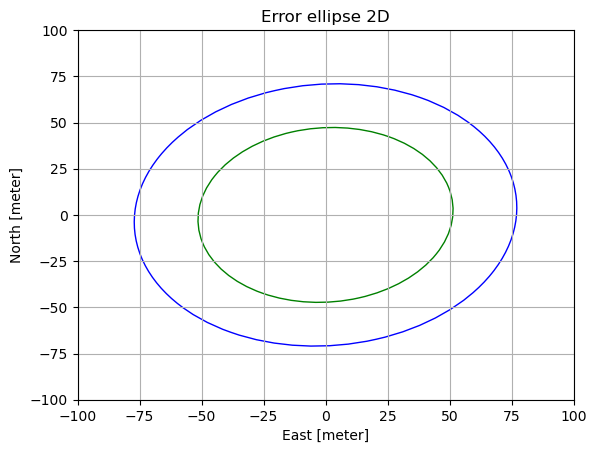

In [6]:
# Cofactor matrix of the residuals
Qv = inv(W) - H@Qx@H.T


# Redundancy
r = diag(Qv@W)


# Plot error ellipse
fig, ax = plt.subplots()

ell1 = error_ellipse2D(0, 0, SIGMAx[0:2, 0:2], sigma=2, ec='green')
ell2 = error_ellipse2D(0, 0, SIGMAx[0:2, 0:2], sigma=3, ec='blue')


ell1.set_facecolor('none')
ax.add_patch(ell1)


ell2.set_facecolor('none')
ax.add_patch(ell2)


plt.title("Error ellipse 2D")
plt.xlabel("East [meter]")
plt.ylabel("North [meter]")
plt.xlim([-100, 100])
plt.ylim([-100, 100])
plt.grid()
plt.show()

In [7]:
# Horizontal dilution of precision (HDOP)
HDOP = sqrt(trace(Qx[0:2, 0:2]))
print("HDOP: {:6.2f}".format(HDOP))


# Distance Root Mean Squared (DRMS)
DRMS = sqrt(trace(SIGMAx[0:2, 0:2]))
print("DRMS: {:6.2f} m".format(DRMS))


# Circular Error Probable (CEP)
CEP = 0.75*DRMS
print("CEP : {:6.2f} m".format(CEP))

HDOP:   0.90
DRMS:  34.94 m
CEP :  26.20 m


In [8]:
# Minimal Detectable Bias (MDB)
lambda0 = 17.075; # i.e. alpha=0.001, gamma=0.80
nablamax = sqrt(lambda0/(r*diag(inv(SIGMAz))))
print(nablamax)

[138.58 129.74 137.75 131.37 130.20]


In [9]:
# Minimal Detectable Error (MDE)
nablax = []
for i in range(0, n):
    nabla = zeros([n, 1])
    nabla[i] = nablamax[i]
    dx = inv(H.T@W@H)@H.T@W@nabla
    nablax.append(dx[0:2])

    
# Maximum effect on the unknowns
index = argmax(norm(nablax, axis=1))
nablaxmax = abs(nablax[index])
print(nablaxmax)

[[58.51]
 [19.18]]
